# Challenge Set 1:  MTA Turnstile Data
#### Exercise 1.1

- Open up a new Jupyter notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where
  there is a key for each (C/A, UNIT, SCP, STATION). These are the
  first four columns. The value for this key should be a list of
  lists. Each list in the list is the rest of the columns in a
  row. For example, one key-value pair should look like


{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],
['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],
['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
...
]
}

In [40]:
import urllib2
response = urllib2.urlopen('http://web.mta.info/developers/turnstile.html')
main_doc = response.read() 

In [41]:
re1='(data)'
re2='(\\/)'
re3='(nyct)'
re4='(\\/)'
re5='(turnstile)'
re6='(\\/)'
re7='(turnstile)'
re8='(_)'
re9='.*?'
re10='(\\.)'
re11='(txt)'

rg = re.compile(re1+re2+re3+re4+re5+re6+re7+re8+re9+re10+re11,re.IGNORECASE|re.DOTALL)

In [42]:
from bs4 import BeautifulSoup
import re 

def txt_link_downloader(main_link):

    soup = BeautifulSoup(main_link, 'html.parser')

    list_of_links = []
    
    for a in soup.find_all('a', href=True):
        if re.search(rg,a['href']):  
            list_of_links.append(a['href'])

    return list_of_links


list_of_links = txt_link_downloader(main_doc)

formatted_links = map(lambda link: 'http://web.mta.info/developers/'+link, list_of_links)

sorted_list = sorted(formatted_links, reverse=True)

In [46]:
import pandas as pd
import urllib

def to_csv_downloader(html_list, n_limit): 
    csv_opener = urllib.URLopener()
    for html_link in html_list[:n_limit]: 
        new_name = html_link[-10:-4] + '.csv'
        csv_opener.retrieve(html_link,new_name)
        
to_csv_downloader(sorted_list,2) # download files 

In [114]:
import glob, os
import pandas as pd 
import csv

def read_dataframe():
    csv_list = []
    for csv_file_name in glob.glob(('[0-9]'*6+'.csv')):
        csv_list.append(pd.read_csv(csv_file_name))
    return pd.concat(csv_list)

df = read_dataframe()

In [155]:
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTERED
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10 00:00:00,
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,04:00:00,REGULAR,5817544,1971940,2016-09-10 04:00:00,


In [159]:
df.columns = df.columns.map(lambda x: str(x).strip())

In [49]:
# so back to the challenge 

dictionary = {}

df.columns = df.columns.map(lambda x: str(x).strip())
usecols = df.columns[4:]

grouped_object = list(df.groupby(['C/A','UNIT','SCP','STATION']))

for group in grouped_object:
    dictionary[group[0]] = group[1][usecols].values

In [52]:
# this is for your visualization
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(2, dictionary.iteritems())
n_items

[(('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD'),
  array([['A', 'IND', '09/10/2016', '01:00:00', 'REGULAR', 7454169, 2939249],
         ['A', 'IND', '09/10/2016', '05:00:00', 'REGULAR', 7454197, 2939268],
         ['A', 'IND', '09/10/2016', '09:00:00', 'REGULAR', 7454413, 2939293],
         ['A', 'IND', '09/10/2016', '13:00:00', 'REGULAR', 7454628, 2939344],
         ['A', 'IND', '09/10/2016', '17:00:00', 'REGULAR', 7454843, 2939404],
         ['A', 'IND', '09/10/2016', '21:00:00', 'REGULAR', 7455027, 2939461],
         ['A', 'IND', '09/11/2016', '01:00:00', 'REGULAR', 7455150, 2939480],
         ['A', 'IND', '09/11/2016', '05:00:00', 'REGULAR', 7455172, 2939487],
         ['A', 'IND', '09/11/2016', '09:00:00', 'REGULAR', 7455306, 2939511],
         ['A', 'IND', '09/11/2016', '13:00:00', 'REGULAR', 7455467, 2939547],
         ['A', 'IND', '09/11/2016', '17:00:00', 'REGULAR', 7455612, 2939595],
         ['A', 'IND', '09/11/2016', '21:00:00', 'REGULAR', 7455783, 2939646],
         ['A', 

#### Exercise 1.2

- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and
 station of a specific turnstile), have a list again, but let the list
 be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields
in each list. You can convert the date and time into datetime objects
-- That is a python class that represents a point in time. You can
combine the date and time fields into a string and use the
[dateutil](https://labix.org/python-dateutil) module to convert it
into a datetime object. For an example check
[this StackOverflow question](http://stackoverflow.com/questions/23385003/attributeerror-when-using-import-dateutil-and-dateutil-parser-parse-but-no).

Your new dict should look something like

{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
[datetime.datetime(2013, 3, 2, 3, 0), 3788],
[datetime.datetime(2013, 3, 2, 7, 0), 2585],
[datetime.datetime(2013, 3, 2, 12, 0), 10653],
[datetime.datetime(2013, 3, 2, 17, 0), 11016],
[datetime.datetime(2013, 3, 2, 23, 0), 10666],
[datetime.datetime(2013, 3, 3, 3, 0), 10814],
[datetime.datetime(2013, 3, 3, 7, 0), 10229],
...
],
....
}

In [53]:
from collections import defaultdict
from dateutil.parser import parse

time_dictionary = {}

for key,values in dictionary.items():
    list_of_times = map(lambda x: [parse(' '.join(x[2:4])), x[5]], values)
    time_dictionary[key] = list_of_times
    
n_items = take(2, time_dictionary.iteritems())
n_items

[(('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD'),
  [[datetime.datetime(2016, 9, 10, 1, 0), 7454169],
   [datetime.datetime(2016, 9, 10, 5, 0), 7454197],
   [datetime.datetime(2016, 9, 10, 9, 0), 7454413],
   [datetime.datetime(2016, 9, 10, 13, 0), 7454628],
   [datetime.datetime(2016, 9, 10, 17, 0), 7454843],
   [datetime.datetime(2016, 9, 10, 21, 0), 7455027],
   [datetime.datetime(2016, 9, 11, 1, 0), 7455150],
   [datetime.datetime(2016, 9, 11, 5, 0), 7455172],
   [datetime.datetime(2016, 9, 11, 9, 0), 7455306],
   [datetime.datetime(2016, 9, 11, 13, 0), 7455467],
   [datetime.datetime(2016, 9, 11, 17, 0), 7455612],
   [datetime.datetime(2016, 9, 11, 21, 0), 7455783],
   [datetime.datetime(2016, 9, 12, 1, 0), 7455880],
   [datetime.datetime(2016, 9, 12, 5, 0), 7455913],
   [datetime.datetime(2016, 9, 12, 9, 0), 7456541],
   [datetime.datetime(2016, 9, 12, 13, 0), 7456842],
   [datetime.datetime(2016, 9, 12, 17, 0), 7457088],
   [datetime.datetime(2016, 9, 12, 21, 0), 7457316],
   [da

#### Exercise 1.3

- These counts are for every n hours. (What is n?) We want total daily
  entries.

Now make it that we again have the same keys, but now we have a single
value for a single day, which is the total number of passengers that
entered through this turnstile on this day.

In [315]:
df['DATETIME'] = df[['DATE','TIME']].apply(lambda x: ' '.join(x),axis=1)
df['DATETIME'] = df['DATETIME'].map(lambda x: parse(x)) 

In [316]:
df.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,04:00:00,REGULAR,5817544,1971940,2016-09-10 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,08:00:00,REGULAR,5817564,1971981,2016-09-10 08:00:00


In [317]:
# with sort_values I only have to display the first entry to confirm whether or not there is 
# a duplicate "C/A", "UNIT", "SCP", "STATION", "DATETIME" combination
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(1)

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-09-10,1


In [318]:
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

In [319]:
df.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10


In [320]:
df.columns

Index([u'C/A', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'DIVISION', u'DATE',
       u'TIME', u'DESC', u'ENTRIES', u'EXITS', u'DATETIME'],
      dtype='object')

In [321]:
pd.options.mode.chained_assignment = None

listz = []  

grouped_object = df.groupby(['C/A','UNIT','SCP','STATION'])

for category, dataframe in grouped_object:    
    
    dataframe['PERIOD_ENTERED'] = (dataframe['ENTRIES'] - dataframe['ENTRIES'].shift()).abs()  
    dataframe['PERIOD_EXITED'] = (dataframe['EXITS'] - dataframe['EXITS'].shift()).abs()
    dataframe['PERIOD_IMPRESSION'] = dataframe['PERIOD_ENTERED'] + dataframe['PERIOD_EXITED']
    
    dataframe.loc[dataframe['PERIOD_ENTERED']>3000, 'PERIOD_ENTERED'] = 0
    dataframe.loc[dataframe['PERIOD_EXITED']>3000, 'PERIOD_EXITED'] = 0
    
    listz.append(dataframe)    
    
df1 = pd.concat(listz, ignore_index=True)
df1.fillna(0, inplace=True)
df1.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PERIOD_ENTERED,PERIOD_EXITED,PERIOD_IMPRESSION
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10 00:00:00,0.0,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,04:00:00,REGULAR,5817544,1971940,2016-09-10 04:00:00,39.0,4.0,43.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,08:00:00,REGULAR,5817564,1971981,2016-09-10 08:00:00,20.0,41.0,61.0


In [322]:
listz = []  

grouped_object = df1.groupby(['C/A','UNIT','SCP','STATION','DATE']) 

for category, dataframe in grouped_object:    
    
    dataframe['DAILY_ENTRY'] = dataframe['PERIOD_ENTERED'].sum()
    dataframe['DAILY_EXIT'] = dataframe['PERIOD_EXITED'].sum()
    dataframe['DAILY_IMPRESSION'] = dataframe['DAILY_ENTRY'] + dataframe['DAILY_EXIT']
    
    listz.append(dataframe)    
    
df2 = pd.concat(listz, ignore_index=True)
df2.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PERIOD_ENTERED,PERIOD_EXITED,PERIOD_IMPRESSION,DAILY_ENTRY,DAILY_EXIT,DAILY_IMPRESSION
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10 00:00:00,0.0,0.0,0.0,742.0,309.0,1051.0
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,04:00:00,REGULAR,5817544,1971940,2016-09-10 04:00:00,39.0,4.0,43.0,742.0,309.0,1051.0


In [323]:
df2.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PERIOD_ENTERED,PERIOD_EXITED,PERIOD_IMPRESSION,DAILY_ENTRY,DAILY_EXIT,DAILY_IMPRESSION
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10 00:00:00,0.0,0.0,0.0,742.0,309.0,1051.0
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,04:00:00,REGULAR,5817544,1971940,2016-09-10 04:00:00,39.0,4.0,43.0,742.0,309.0,1051.0


#### Exercise 1.4

We will plot the daily time series for a turnstile.

In Jupyter notebook, add this to the beginning of your next cell:

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the
notebook. To plot the time series, import matplotlib with

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the
turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)

In [324]:
df2.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PERIOD_ENTERED,PERIOD_EXITED,PERIOD_IMPRESSION,DAILY_ENTRY,DAILY_EXIT,DAILY_IMPRESSION
0,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,00:00:00,REGULAR,5817505,1971936,2016-09-10 00:00:00,0.0,0.0,0.0,742.0,309.0,1051.0
1,A002,R051,02-00-00,59 ST,NQR456,BMT,09/10/2016,04:00:00,REGULAR,5817544,1971940,2016-09-10 04:00:00,39.0,4.0,43.0,742.0,309.0,1051.0


In [325]:
# we just need one value of the groupby object for unique turnstile total daily entry count
# this is one way but I later realized there were two better methods 
df2.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])['DAILY_ENTRY'].apply(lambda x:x[0:1]).reset_index().head()

,C/A,UNIT,SCP,STATION,DATE,level_5,0
0,A002,R051,02-00-00,59 ST,09/10/2016,0,742.0
1,A002,R051,02-00-00,59 ST,09/11/2016,6,727.0
2,A002,R051,02-00-00,59 ST,09/12/2016,12,1574.0
3,A002,R051,02-00-00,59 ST,09/13/2016,18,1724.0
4,A002,R051,02-00-00,59 ST,09/14/2016,24,1760.0


In [461]:
df2.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])[['DAILY_ENTRY']].nth(0).head()

DAILY_ENTRY
C/A  UNIT SCP      STATION DATE                   
A002 R051 02-00-00 59 ST   09/10/2016        742.0
                           09/11/2016        727.0
                           09/12/2016       1574.0
                           09/13/2016       1724.0
                           09/14/2016       1760.0

In [465]:
df2.set_index('DATETIME',inplace=True)

In [466]:
df2.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])[['DAILY_ENTRY']].resample('1w',how='sum')

/Users/dhkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


DAILY_ENTRY
C/A   UNIT SCP      STATION       DATE       DATETIME               
A002  R051 02-00-00 59 ST         09/10/2016 2016-09-11       4452.0
                                  09/11/2016 2016-09-11       4362.0
                                  09/12/2016 2016-09-18       9444.0
                                  09/13/2016 2016-09-18      10344.0
                                  09/14/2016 2016-09-18      10560.0
                                  09/15/2016 2016-09-18      10650.0
                                  09/16/2016 2016-09-18      10740.0
                                  09/17/2016 2016-09-18       6690.0
                                  09/18/2016 2016-09-18       4404.0
                                  09/19/2016 2016-09-25       9696.0
                                  09/20/2016 2016-09-25      10668.0
                                  09/21/2016 2016-09-25      10890.0
                                  09/22/2016 2016-09-25      10662.0
                                  09/23/2016 2016-09-25      10812.0
           02-00-01 59 ST         09/10/2016 2016-09-11       4026.0
                                  09/11/2016 2016-09-11       4050.0
                                  09/12/2016 2016-09-18       7812.0
                                  09/13/2016 2016-09-18       8868.0
                                  09/14/2016 2016-09-18       8904.0
                                  09/15/2016 2016-09-18       8436.0
                                  09/16/2016 2016-09-18       8916.0
                                  09/17/2016 2016-09-18       5916.0
                                  09/18/2016 2016-09-18       4110.0
                                  09/19/2016 2016-09-25       7986.0
                                  09/20/2016 2016-09-25       9234.0
                                  09/21/2016 2016-09-25       8778.0
                                  09/22/2016 2016-09-25       8730.0
                                  09/23/2016 2016-09-25       9360.0
           02-03-00 59 ST         09/10/2016 2016-09-11       3378.0
                                  09/11/2016 2016-09-11       3822.0
...                                                              ...
TRAM2 R469 00-03-01 RIT-ROOSEVELT 09/22/2016 2016-09-25       1530.0
                                  09/23/2016 2016-09-25       1878.0
           00-05-00 RIT-ROOSEVELT 09/10/2016 2016-09-11         12.0
                                  09/11/2016 2016-09-11          0.0
                                  09/12/2016 2016-09-18          6.0
                                  09/13/2016 2016-09-18         18.0
                                  09/14/2016 2016-09-18          6.0
                                  09/15/2016 2016-09-18          6.0
                                  09/16/2016 2016-09-18         12.0
                                  09/17/2016 2016-09-18         18.0
                                  09/18/2016 2016-09-18          0.0
                                  09/19/2016 2016-09-25          0.0
                                  09/20/2016 2016-09-25         12.0
                                  09/21/2016 2016-09-25          0.0
                                  09/22/2016 2016-09-25          0.0
                                  09/23/2016 2016-09-25          0.0
           00-05-01 RIT-ROOSEVELT 09/10/2016 2016-09-11          0.0
                                  09/11/2016 2016-09-11          0.0
                                  09/12/2016 2016-09-18          0.0
                                  09/13/2016 2016-09-18          0.0
                                  09/14/2016 2016-09-18          0.0
                                  09/15/2016 2016-09-18          0.0
                                  09/16/2016 2016-09-18          0.0
                                  09/17/2016 2016-09-18          0.0
                                  09/18/2016 2016-09-18          0.0
                                  09/19/2016 2016-09-25

In [326]:
# these two are easier to follow (by the way sometimes it's important to think about whether 
# or not you need single bracket [] or double bracket [[]]
# single is to return a Series while double is for returning a DataFrame
# sometimes it also depends on the method 

df2.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])[['DAILY_ENTRY']].nth(0).head()
df2.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])['DAILY_ENTRY'].first().reset_index()

df2_daily = df2.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])['DAILY_ENTRY'].first().reset_index()
df2_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRY
0,A002,R051,02-00-00,59 ST,09/10/2016,742.0
1,A002,R051,02-00-00,59 ST,09/11/2016,727.0
2,A002,R051,02-00-00,59 ST,09/12/2016,1574.0
3,A002,R051,02-00-00,59 ST,09/13/2016,1724.0
4,A002,R051,02-00-00,59 ST,09/14/2016,1760.0


In [327]:
import matplotlib.pyplot as plt 
%matplotlib inline 

In [328]:
# we should note that without loss of generality it can be shown that plotting one turnstile 
# can be applied to plotting multiple (for loop / groupby / others)

In [329]:
df2_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRY
0,A002,R051,02-00-00,59 ST,09/10/2016,742.0
1,A002,R051,02-00-00,59 ST,09/11/2016,727.0
2,A002,R051,02-00-00,59 ST,09/12/2016,1574.0
3,A002,R051,02-00-00,59 ST,09/13/2016,1724.0
4,A002,R051,02-00-00,59 ST,09/14/2016,1760.0


In [330]:
df2_daily['DATE'] = df2_daily['DATE'].map(lambda x: parse(x))

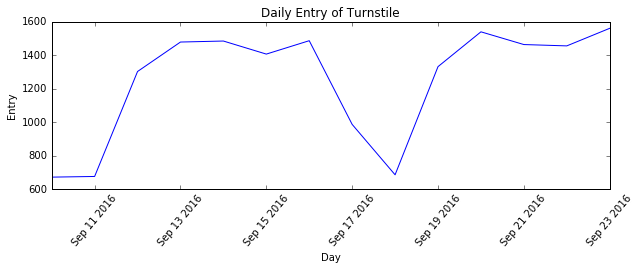

In [331]:
import matplotlib.pyplot as plt 
%matplotlib inline 

def turnstile_plotter(ca,unit,scp,station,dataframe): 
    turnstile_index = ((dataframe["C/A"] == ca) & 
                      (dataframe["UNIT"] == unit) &
                      (dataframe["SCP"] == scp) & 
                      (dataframe["STATION"] == station))
    
    daily_df = dataframe[turnstile_index]

    date = daily_df["DATE"]
    daily_entry = daily_df["DAILY_ENTRY"]
    
    plt.figure(figsize=(10,3))
    plt.xticks(rotation=50)
    plt.ylabel('Entry')
    plt.xlabel('Day')
    plt.title('Daily Entry of Turnstile')
    
    return plt.plot(date,daily_entry)
    
turnstile_plotter('A002','R051','02-00-01','59 ST', df2_daily)

#### Exercise 1.5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.

In [332]:
df2_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRY
0,A002,R051,02-00-00,59 ST,2016-09-10,742.0
1,A002,R051,02-00-00,59 ST,2016-09-11,727.0
2,A002,R051,02-00-00,59 ST,2016-09-12,1574.0
3,A002,R051,02-00-00,59 ST,2016-09-13,1724.0
4,A002,R051,02-00-00,59 ST,2016-09-14,1760.0


In [333]:
turnstile_cluster = (df2_daily
                     .groupby(['C/A','UNIT','STATION','DATE'])['DAILY_ENTRY']
                     .sum()
                     .reset_index())

In [334]:
turnstile_cluster.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRY
0,A002,R051,59 ST,2016-09-10,8037.0
1,A002,R051,59 ST,2016-09-11,8339.0
2,A002,R051,59 ST,2016-09-12,16101.0
3,A002,R051,59 ST,2016-09-13,18075.0
4,A002,R051,59 ST,2016-09-14,18213.0


#### Exercise 1.6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.


In [335]:
station_cluster = (turnstile_cluster
                     .groupby(['STATION','DATE'])['DAILY_ENTRY']
                     .sum()
                     .reset_index()
                     )

In [336]:
station_cluster.head()

,STATION,DATE,DAILY_ENTRY
0,1 AV,2016-09-10,14615.0
1,1 AV,2016-09-11,15778.0
2,1 AV,2016-09-12,19249.0
3,1 AV,2016-09-13,22949.0
4,1 AV,2016-09-14,23671.0


#### Exercise 1.7

Plot the time series for a station.

In [337]:
# select an arbitrary station

In [338]:
station_cluster.head()

,STATION,DATE,DAILY_ENTRY
0,1 AV,2016-09-10,14615.0
1,1 AV,2016-09-11,15778.0
2,1 AV,2016-09-12,19249.0
3,1 AV,2016-09-13,22949.0
4,1 AV,2016-09-14,23671.0


In [341]:
station_cluster['DATE'] = pd.to_datetime(station_cluster['DATE'], format='%y/%m/%d')

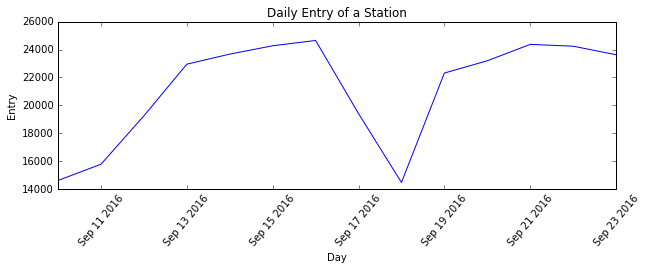

In [342]:
import matplotlib.pyplot as plt 
%matplotlib inline 

def station_plotter(station,dataframe): 
    station_index = (dataframe["STATION"] == station)
    
    daily_df = dataframe[station_index]

    date = daily_df["DATE"]
    daily_entry = daily_df["DAILY_ENTRY"]
    
    plt.figure(figsize=(10,3))
    plt.xticks(rotation=50)
    plt.ylabel('Entry')
    plt.xlabel('Day')
    plt.title('Daily Entry of a Station')
    
    return plt.plot(date,daily_entry)
    
station_plotter('1 AV', station_cluster)

#### Exercise 1.8

- Make one list of counts for **one** week for one station. Monday's
count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another
week.
`plt.plot(week_count_list)` for every `week_count_list` you created
this way. You should get a rainbow plot of weekly commute numbers on
top of each other.

In [343]:
station_cluster.head()

,STATION,DATE,DAILY_ENTRY
0,1 AV,2016-09-10,14615.0
1,1 AV,2016-09-11,15778.0
2,1 AV,2016-09-12,19249.0
3,1 AV,2016-09-13,22949.0
4,1 AV,2016-09-14,23671.0


[(36,   STATION       DATE  DAILY_ENTRY
0    1 AV 2016-09-10      14615.0
1    1 AV 2016-09-11      15778.0), (37,   STATION       DATE  DAILY_ENTRY
2    1 AV 2016-09-12      19249.0
3    1 AV 2016-09-13      22949.0
4    1 AV 2016-09-14      23671.0
5    1 AV 2016-09-15      24269.0
6    1 AV 2016-09-16      24650.0
7    1 AV 2016-09-17      19406.0
8    1 AV 2016-09-18      14472.0), (38,    STATION       DATE  DAILY_ENTRY
9     1 AV 2016-09-19      22314.0
10    1 AV 2016-09-20      23194.0
11    1 AV 2016-09-21      24368.0
12    1 AV 2016-09-22      24238.0
13    1 AV 2016-09-23      23626.0)]


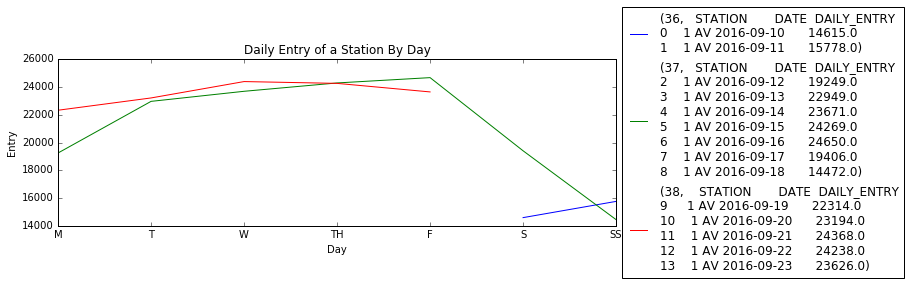

In [411]:
def week_station_plotter(station,dataframe): 
    
    plt.figure(figsize=(10,3))
    
    station_index = (dataframe["STATION"] == station)
    
    daily_df = dataframe[station_index]
    grouped = daily_df.groupby([daily_df['DATE'].map(lambda x: x.isocalendar()[1])])
    print list(grouped)
    
    for index,group in grouped: 
        date = group["DATE"].map(lambda x:x.isoweekday())
        daily_entry = group["DAILY_ENTRY"]
        plt.plot(date,daily_entry)
        
    plt.xticks([1,2,3,4,5,6,7],['M','T','W','TH','F','S','SS'])
    plt.legend(grouped,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Daily Entry of a Station By Day')
    plt.xlabel('Day')
    plt.ylabel('Entry')

    
week_station_plotter('1 AV', station_cluster)

#### Exercise 1.9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate

In [ ]:
# you can get more creative than me here and specify setting the datetime as index and resampling
# or groupby week or month to detemrine 

In [460]:
df2_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRY
0,A002,R051,02-00-00,59 ST,2016-09-10,742.0
1,A002,R051,02-00-00,59 ST,2016-09-11,727.0
2,A002,R051,02-00-00,59 ST,2016-09-12,1574.0
3,A002,R051,02-00-00,59 ST,2016-09-13,1724.0
4,A002,R051,02-00-00,59 ST,2016-09-14,1760.0


In [459]:
df2_daily.set_index('DATE').resample('1W',how='sum')

/Users/dhkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


,DAILY_ENTRY
DATE,
2016-09-11,5790742.0
2016-09-18,37190245.0
2016-09-25,30958837.0


In [412]:
df2_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRY
0,A002,R051,02-00-00,59 ST,2016-09-10,742.0
1,A002,R051,02-00-00,59 ST,2016-09-11,727.0
2,A002,R051,02-00-00,59 ST,2016-09-12,1574.0
3,A002,R051,02-00-00,59 ST,2016-09-13,1724.0
4,A002,R051,02-00-00,59 ST,2016-09-14,1760.0


In [422]:
df2_daily.groupby(['STATION'])[['DAILY_ENTRY']].sum().head()

,STATION,DAILY_ENTRY
0,1 AV,296799.0
1,103 ST,363206.0
2,103 ST-CORONA,269935.0
3,104 ST,60323.0
4,110 ST,163383.0


In [429]:
station_totals=(df2_daily
                .groupby("STATION")['DAILY_ENTRY'].sum()
                .reset_index()
                .sort_values("DAILY_ENTRY", ascending=False)
                )
station_totals.head()

,STATION,DAILY_ENTRY
61,34 ST-PENN STA,2072154.0
230,GRD CNTRL-42 ST,1842183.0
46,23 ST,1542058.0
59,34 ST-HERALD SQ,1487660.0
109,86 ST,1370356.0


#### Exercise 1.10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))

(array([ 272.,   65.,   16.,    6.,    5.,    3.,    3.,    2.,    1.,    1.]),
 array([  1.40000000e+01,   2.07228000e+05,   4.14442000e+05,
          6.21656000e+05,   8.28870000e+05,   1.03608400e+06,
          1.24329800e+06,   1.45051200e+06,   1.65772600e+06,
          1.86494000e+06,   2.07215400e+06]),
 <a list of 10 Patch objects>)

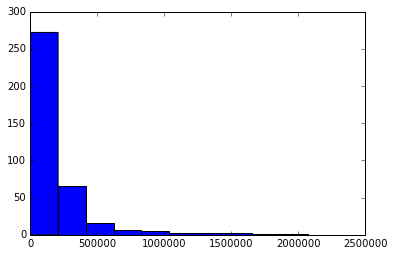

In [435]:
plt.hist(station_totals["DAILY_ENTRY"])

In [ ]:
# too much data so without loss of generality, limit scope to few

In [453]:
sample_station_totals = station_totals.head(10)
sample_station_totals

,STATION,DAILY_ENTRY
61,34 ST-PENN STA,2072154.0
230,GRD CNTRL-42 ST,1842183.0
46,23 ST,1542058.0
59,34 ST-HERALD SQ,1487660.0
109,86 ST,1370356.0
14,14 ST-UNION SQ,1356074.0
68,42 ST-PORT AUTH,1267658.0
349,TIMES SQ-42 ST,1233784.0
223,FULTON ST,1195311.0
9,125 ST,1052901.0


In [454]:
indices = range(len(sample_station_totals))
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

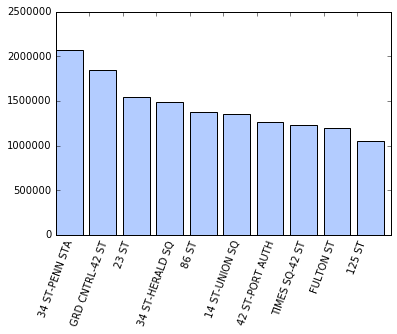

In [456]:
plt.bar(indices,sample_station_totals['DAILY_ENTRY'], color="#b3ccff")


plt.xticks(indices,sample_station_totals['STATION'], rotation=70)
plt.xlabel()

plt.show()